In [13]:
import sys

sys.path.insert(0,'/home/mmo-gog/dpsim/build/')
sys.path.insert(0,'/home/mmo-gog/dpsim/python/src/dpsim')

import iaewreader
import dpsimpy

from villas.dataprocessing.timeseries import TimeSeries as ts
import villas.dataprocessing.plottools as pt

from villas.dataprocessing.readtools import *
from villas.dataprocessing.timeseries import *
import urllib.request
import matplotlib.pyplot as plt
import numpy as np
import math

%matplotlib widget

In [14]:
#File from=1, to =4
path_file = '/home/mmo-gog/dpsim/examples/Notebooks/9BusValidations/Static_Dynamic_Data_9Bus_System.mat'
#File from=4, to =1
#path_file = '/home/mmo-gog/dpsim/examples/Notebooks/9BusValidations/Static_Dynamic_Data_9Bus_System_incl_simulations.mat'

Power Flow Simulation

In [15]:
sim_name_pf = '9Bus_SYN_PF'
dpsimpy.Logger.set_log_dir('logs/' + sim_name_pf)

# read and create dpsim topology
mpc_reader = iaewreader.Reader(mpc_file_path=path_file, mpc_name='case9_static_only_SYN')
mpc_reader.load_mpc(domain=iaewreader.Domain.PF)
system_pf = mpc_reader.system

# log results
logger = dpsimpy.Logger(sim_name_pf)
for node in system_pf.nodes:
    logger.log_attribute(node.name()+'.V', 'v', node)
    logger.log_attribute(node.name()+'.S', 's', node)

# Parametrize and run simulation
sim_pf = dpsimpy.Simulation(sim_name_pf, dpsimpy.LogLevel.info)
sim_pf.set_system(system_pf)
sim_pf.set_time_step(0.1)
sim_pf.set_final_time(0.1)
sim_pf.set_domain(dpsimpy.Domain.SP)
sim_pf.set_solver(dpsimpy.Solver.NRP)
sim_pf.do_init_from_nodes_and_terminals(False)
sim_pf.set_solver_component_behaviour(dpsimpy.SolverBehaviour.Initialization)
sim_pf.add_logger(logger)
sim_pf.run()

dpsim_result_file = 'logs/' + sim_name_pf + '/' + sim_name_pf + '.csv'
ts_dpsim_pf = read_timeseries_csv(dpsim_result_file)

dpsim_results = pd.DataFrame(columns=['Bus', 'V_mag(pu)', 'V_angle(deg)', 'P(MW)', 'Q(MVAr)'])
base_power = 1 #mw
for i in range(len(system_pf.nodes)):
    node_name = system_pf.nodes[i].name() #ex. N5
    node_number = node_name.replace('N', '')
    node_baseV = mpc_reader.mpc_bus_data.loc[mpc_reader.mpc_bus_data['bus_i'] == int(node_number), 'baseKV'].iloc[0] * 1e3
    w_mw = 1e-6
    dpsim_results.loc[i] = ([node_name] + [round(np.absolute(ts_dpsim_pf[node_name + '.V'].values[-1]) / node_baseV, 3)]
        + [round(np.angle(ts_dpsim_pf[node_name + '.V'].values[-1])*180/np.pi, 3)] 
        + [round(w_mw * np.real(ts_dpsim_pf[node_name + '.S'].values[-1]) / base_power, 3)] 
        + [round(w_mw * np.imag(ts_dpsim_pf[node_name + '.S'].values[-1]) / base_power, 3)])

dpsim_results

column number: 24
results length: 2
real column names: []
complex column names: ['N1.S', 'N1.V', 'N10.S', 'N10.V', 'N11.S', 'N11.V', 'N12.S', 'N12.V', 'N2.S', 'N2.V', 'N3.S', 'N3.V', 'N4.S', 'N4.V', 'N5.S', 'N5.V', 'N6.S', 'N6.V', 'N7.S', 'N7.V', 'N8.S', 'N8.V', 'N9.S', 'N9.V']


[18:18:02.491287 9Bus_SYN_PF info] Initialize simulation: 9Bus_SYN_PF
[18:18:02.491679 9Bus_SYN_PF_PF_Solver warning] Unable to get base voltage at N4
[18:18:02.491686 9Bus_SYN_PF_PF_Solver warning] Unable to get base voltage at N5
[18:18:02.491689 9Bus_SYN_PF_PF_Solver warning] Unable to get base voltage at N6
[18:18:02.491694 9Bus_SYN_PF_PF_Solver warning] Unable to get base voltage at N7
[18:18:02.491697 9Bus_SYN_PF_PF_Solver warning] Unable to get base voltage at N8
[18:18:02.491700 9Bus_SYN_PF_PF_Solver warning] Unable to get base voltage at N9
[18:18:02.491702 9Bus_SYN_PF_PF_Solver warning] Unable to get base voltage at N10
[18:18:02.491705 9Bus_SYN_PF_PF_Solver warning] Unable to get base voltage at N11
[18:18:02.491708 9Bus_SYN_PF_PF_Solver warning] Unable to get base voltage at N12
[18:18:02.491908 9Bus_SYN_PF info] Scheduling tasks.
[18:18:02.492071 9Bus_SYN_PF info] Scheduling done.
[18:18:02.492072 9Bus_SYN_PF info] Opening interfaces.
[18:18:02.492073 9Bus_SYN_PF info] Sta

,Bus,V_mag(pu),V_angle(deg),P(MW),Q(MVAr)
0,N1,1.000,0.000,474.429,86.892
1,N2,1.100,-8.001,120.000,189.324
2,N3,1.000,-7.171,120.000,10.745
3,N4,1.044,-3.103,-0.000,0.000
4,N5,0.998,-8.729,-0.000,0.000
5,N6,0.997,-9.193,0.000,0.000
6,N7,0.979,-14.072,-0.000,0.000
7,N8,1.050,-9.747,0.000,0.000
8,N9,1.031,-9.042,-0.000,0.000
9,N10,0.981,-12.166,-200.000,-50.000


SP dynamic simulation

In [17]:
sim_name_dyn_sp = 'SP_only_SYN_case9_dyn'
dpsimpy.Logger.set_log_dir('logs/' + sim_name_dyn_sp)

mpc_reader = iaewreader.Reader(mpc_file_path=path_file, mpc_name='case9_static_only_SYN', 
                             mpc_dyn_file_path=path_file, mpc_dyn_name='case9_dyn_only_SYN')
mpc_reader.create_dpsim_objects(domain=iaewreader.Domain.SP, frequency=50, with_avr=True, with_tg=True, with_pss=False)
#create a switch
sw = dpsimpy.sp.ph1.Switch('Fault', dpsimpy.LogLevel.info)
switch_closed = 0.0001

sw.set_parameters(1e18, switch_closed)
sw.open()
mpc_reader.dpsimpy_comp_dict['Fault'] = [sw]
#Node 11 is the load at 100kV, node 7 ist a node of 400kV grid, there is a transformer between Node 7 and 11 
mpc_reader.dpsimpy_comp_dict['Fault'].append([dpsimpy.sp.SimNode.gnd, mpc_reader.dpsimpy_busses_dict["N4"]])

# create dpsim topology
system_dyn = mpc_reader.create_dpsim_topology()

#initialize node voltages using pf results
system_dyn = mpc_reader.system
system_dyn.init_with_powerflow(system_pf)

logger = dpsimpy.Logger(sim_name_dyn_sp)
for node in system_dyn.nodes:
    logger.log_attribute(node.name()+'.V', 'v', node)

# Log electrical power and omega of SGs
for gen_name in ["Gen_N1", "Gen_N2", "Gen_N3"]:
    logger.log_attribute('{}.Pe'.format(gen_name), 'Te', mpc_reader.dpsimpy_comp_dict[gen_name][0])
    logger.log_attribute('{}.w'.format(gen_name), 'w_r', mpc_reader.dpsimpy_comp_dict[gen_name][0])
    logger.log_attribute('{}.Pm'.format(gen_name), 'Tm', mpc_reader.dpsimpy_comp_dict[gen_name][0])

# Parametrize and run simulation
sim = dpsimpy.Simulation(sim_name_dyn_sp, dpsimpy.LogLevel.info)
sim.set_system(system_dyn)
sim.set_time_step(1e-3)
sim.set_final_time(100)
sim.set_domain(dpsimpy.Domain.SP)
sim.set_solver(dpsimpy.Solver.MNA)
sim.set_direct_solver_implementation(dpsimpy.DirectLinearSolverImpl.SparseLU)
sim.do_init_from_nodes_and_terminals(True)
sim.do_system_matrix_recomputation(True)
sim.add_logger(logger)

# add event
sw_event_1 = dpsimpy.event.SwitchEvent(35, sw, True)
sw_event_2 = dpsimpy.event.SwitchEvent(35.1, sw, False)
sim.add_event(sw_event_1)
sim.add_event(sw_event_2)

sim.run()

   bus  model       BaseS    H    D        Xd        Xq  Xd_t  Xq_t  Xd_s  \
0  1.0    2.0  670.820393  2.0  0.1  1.811215  1.646559   0.3   0.4   0.2   
1  2.0    2.0  500.000000  2.0  0.1  1.811215  1.646559   0.3   0.4   0.2   
2  3.0    2.0  500.000000  2.0  0.1  1.811215  1.646559   0.3   0.4   0.2   

   Xq_s  Td0_t  Tq0_t  Td0_s  Tq0_s   Ra  
0   0.2    7.0    1.5   0.05   0.05  0.0  
1   0.2    7.0    1.5   0.05   0.05  0.0  
2   0.2    7.0    1.5   0.05   0.05  0.0  
   bus  Type     Ka    Te   Ta    Tb  U_max  U_min   Kbc
0  1.0   2.0  200.0  0.05  3.0  10.0   -4.0    4.0  10.0
1  2.0   2.0  200.0  0.05  3.0  10.0   -4.0    4.0  10.0
2  3.0   2.0  200.0  0.05  3.0  10.0   -4.0    4.0  10.0
   bus  Type   Tw    T1    T2    T3     T4    Ks  U_smin  U_smax
0  1.0   1.0  2.0  0.25  0.03  0.15  0.015  10.0    -0.1     0.1
1  2.0   1.0  2.0  0.25  0.03  0.15  0.015  10.0    -0.1     0.1
2  3.0   1.0  2.0  0.25  0.03  0.15  0.015  10.0    -0.1     0.1
   bus  Type    K   T1       T2

[18:18:53.917330 SP_only_SYN_case9_dyn info] Initialize simulation: SP_only_SYN_case9_dyn
[18:18:53.917427 MnaSolverFactory info] creating SparseLUAdapter solver implementation


RuntimeError: std::exception

DP dynamic simulation

In [6]:
sim_name_dyn_dp = 'DP_only_SYN_case9_dyn'
dpsimpy.Logger.set_log_dir('logs/' + sim_name_dyn_dp)

mpc_reader = iaewreader.Reader(mpc_file_path=path_file, mpc_name='case9_static_only_SYN', 
                             mpc_dyn_file_path=path_file, mpc_dyn_name='case9_dyn_only_SYN')
mpc_reader.create_dpsim_objects(domain=iaewreader.Domain.DP, frequency=50, with_avr=True, with_tg=True, with_pss=True)
#create a switch
sw = dpsimpy.dp.ph1.Switch('Fault', dpsimpy.LogLevel.info)
switch_closed = 0.2
sw.set_parameters(1e18, switch_closed)
sw.open()
mpc_reader.dpsimpy_comp_dict['Fault'] = [sw]
#Node 11 is the load at 100kV, node 7 ist a node of 400kV grid, between Node 7 and 11 there is a transformer
mpc_reader.dpsimpy_comp_dict['Fault'].append([dpsimpy.dp.SimNode.gnd, mpc_reader.dpsimpy_busses_dict["N4"]])

# create dpsim topology
system_dyn = mpc_reader.create_dpsim_topology()

#initialize node voltages using pf results
system_dyn = mpc_reader.system
system_dyn.init_with_powerflow(system_pf)

logger = dpsimpy.Logger(sim_name_dyn_dp)
for node in system_dyn.nodes:
    logger.log_attribute(node.name()+'.V', 'v', node)
# Log electrical power and omega of SGs
for gen_name in ["Gen_N1", "Gen_N2", "Gen_N3"]:
    logger.log_attribute('{}.Pe'.format(gen_name), 'Te', mpc_reader.dpsimpy_comp_dict[gen_name][0])
    logger.log_attribute('{}.w'.format(gen_name), 'w_r', mpc_reader.dpsimpy_comp_dict[gen_name][0])
    
# Parametrize and run simulation
sim = dpsimpy.Simulation(sim_name_dyn_dp, dpsimpy.LogLevel.info)
sim.set_system(system_dyn)
sim.set_time_step(1e-4)
sim.set_final_time(2.5)
sim.set_domain(dpsimpy.Domain.DP)
sim.set_solver(dpsimpy.Solver.MNA)
sim.set_direct_solver_implementation(dpsimpy.DirectLinearSolverImpl.SparseLU)
sim.do_init_from_nodes_and_terminals(True)
sim.do_system_matrix_recomputation(True)
sim.add_logger(logger)

# add event
sw_event_1 = dpsimpy.event.SwitchEvent(0.1, sw, True)
sw_event_2 = dpsimpy.event.SwitchEvent(0.25, sw, False)
sim.add_event(sw_event_1)
sim.add_event(sw_event_2)

sim.run()

   bus  model       BaseS    H    D        Xd        Xq  Xd_t  Xq_t  Xd_s  \
0  1.0    2.0  670.820393  2.0  0.1  1.811215  1.646559   0.3   0.4   0.2   
1  2.0    2.0  500.000000  2.0  0.1  1.811215  1.646559   0.3   0.4   0.2   
2  3.0    2.0  500.000000  2.0  0.1  1.811215  1.646559   0.3   0.4   0.2   

   Xq_s  Td0_t  Tq0_t  Td0_s  Tq0_s   Ra  
0   0.2    7.0    1.5   0.05   0.05  0.0  
1   0.2    7.0    1.5   0.05   0.05  0.0  
2   0.2    7.0    1.5   0.05   0.05  0.0  
   bus  Type     Ka    Te   Ta    Tb  U_max  U_min   Kbc
0  1.0   2.0  200.0  0.05  3.0  10.0   -4.0    4.0  10.0
1  2.0   2.0  200.0  0.05  3.0  10.0   -4.0    4.0  10.0
2  3.0   2.0  200.0  0.05  3.0  10.0   -4.0    4.0  10.0
   bus  Type   Tw    T1    T2    T3     T4    Ks  U_smin  U_smax
0  1.0   1.0  2.0  0.25  0.03  0.15  0.015  10.0    -0.1     0.1
1  2.0   1.0  2.0  0.25  0.03  0.15  0.015  10.0    -0.1     0.1
2  3.0   1.0  2.0  0.25  0.03  0.15  0.015  10.0    -0.1     0.1
   bus  Type    K   T1       T2

[18:47:30.645957 DP_only_SYN_case9_dyn info] Initialize simulation: DP_only_SYN_case9_dyn


2.500000e-01: Handle event time


[18:47:30.646063 MnaSolverFactory info] creating SparseLUAdapter solver implementation
[18:47:30.647784 Gen_N1 error] 
PSS can not be used without Exciter! PSS will be ignored!
[18:47:30.647809 Gen_N2 error] 
PSS can not be used without Exciter! PSS will be ignored!
[18:47:30.647825 Gen_N3 error] 
PSS can not be used without Exciter! PSS will be ignored!
[18:47:30.648221 DP_only_SYN_case9_dyn_Solver warning] Linear solver configuration is not used!
[18:47:30.650742 DP_only_SYN_case9_dyn info] Scheduling tasks.
[18:47:30.651010 DP_only_SYN_case9_dyn info] Scheduling done.
[18:47:30.651012 DP_only_SYN_case9_dyn info] Opening interfaces.
[18:47:30.651014 DP_only_SYN_case9_dyn info] Start synchronization with remotes on interfaces
[18:47:30.651015 DP_only_SYN_case9_dyn info] Synchronized simulation start with remotes
[18:47:30.651016 DP_only_SYN_case9_dyn info] Start simulation: DP_only_SYN_case9_dyn
[18:47:30.651018 DP_only_SYN_case9_dyn info] Time step: 1.000000e-04
[18:47:30.651020 DP_o

EMT dynamic Simulation

In [7]:
sim_name_dyn_emt = 'EMT_only_SYN_case9_dyn'
dpsimpy.Logger.set_log_dir('logs/' + sim_name_dyn_emt)

# read and create dpsim topology
mpc_reader = iaewreader.Reader(mpc_file_path=path_file, mpc_name='case9_static_only_SYN', 
                             mpc_dyn_file_path=path_file, mpc_dyn_name='case9_dyn_only_SYN')
mpc_reader.create_dpsim_objects(domain=iaewreader.Domain.EMT, frequency=50, log_level=dpsimpy.LogLevel.info, 
                                 with_avr=False, with_tg=True, with_pss=True)

#Fault at node 11 is the load at 100kV, node 7 ist a node of 400kV grid, between Node 7 and 11 there is a transformer
sw = dpsimpy.emt.ph3.SeriesSwitch('Fault', dpsimpy.LogLevel.info)
switch_closed = 0.2
sw.set_parameters(1e18, switch_closed)
sw.open()
mpc_reader.dpsimpy_comp_dict['Fault'] = [sw]
mpc_reader.dpsimpy_comp_dict['Fault'].append([dpsimpy.emt.SimNode.gnd, mpc_reader.dpsimpy_busses_dict["N4"]])

# create dpsim topology
mpc_reader.create_dpsim_topology()

#initialize node voltages using pf results
system_dyn = mpc_reader.system
system_dyn.init_with_powerflow(system_pf, dpsimpy.Domain.EMT)

# log results
logger = dpsimpy.Logger(sim_name_dyn_emt)
for node in system_dyn.nodes:
    logger.log_attribute(node.name()+'.V', 'v', node)
# Log electrical power and omega of SGs
for gen_name in ["Gen_N1", "Gen_N2", "Gen_N3"]:
    logger.log_attribute('{}.Pe'.format(gen_name), 'Te', mpc_reader.dpsimpy_comp_dict[gen_name][0])
    logger.log_attribute('{}.w'.format(gen_name), 'w_r', mpc_reader.dpsimpy_comp_dict[gen_name][0])
     
# Parametrize and run simulation
sim = dpsimpy.Simulation(sim_name_dyn_emt, dpsimpy.LogLevel.debug)
sim.set_system(system_dyn)
sim.set_time_step(1e-4)
sim.set_final_time(2.5)
sim.set_domain(dpsimpy.Domain.EMT)
sim.set_solver(dpsimpy.Solver.MNA)
sim.set_direct_solver_implementation(dpsimpy.DirectLinearSolverImpl.SparseLU)
sim.do_init_from_nodes_and_terminals(True)
sim.do_system_matrix_recomputation(True)
sim.add_logger(logger)

# add events
sw_event_1 = dpsimpy.event.SwitchEvent(0.1, sw, True)
sw_event_2 = dpsimpy.event.SwitchEvent(0.25, sw, False)
sim.add_event(sw_event_1)
sim.add_event(sw_event_2)

sim.set_time_step(1e-4)
sim.run()

   bus  model       BaseS    H    D        Xd        Xq  Xd_t  Xq_t  Xd_s  \
0  1.0    2.0  670.820393  2.0  0.1  1.811215  1.646559   0.3   0.4   0.2   
1  2.0    2.0  500.000000  2.0  0.1  1.811215  1.646559   0.3   0.4   0.2   
2  3.0    2.0  500.000000  2.0  0.1  1.811215  1.646559   0.3   0.4   0.2   

   Xq_s  Td0_t  Tq0_t  Td0_s  Tq0_s   Ra  
0   0.2    7.0    1.5   0.05   0.05  0.0  
1   0.2    7.0    1.5   0.05   0.05  0.0  
2   0.2    7.0    1.5   0.05   0.05  0.0  
   bus  Type     Ka    Te   Ta    Tb  U_max  U_min   Kbc
0  1.0   2.0  200.0  0.05  3.0  10.0   -4.0    4.0  10.0
1  2.0   2.0  200.0  0.05  3.0  10.0   -4.0    4.0  10.0
2  3.0   2.0  200.0  0.05  3.0  10.0   -4.0    4.0  10.0
   bus  Type   Tw    T1    T2    T3     T4    Ks  U_smin  U_smax
0  1.0   1.0  2.0  0.25  0.03  0.15  0.015  10.0    -0.1     0.1
1  2.0   1.0  2.0  0.25  0.03  0.15  0.015  10.0    -0.1     0.1
2  3.0   1.0  2.0  0.25  0.03  0.15  0.015  10.0    -0.1     0.1
   bus  Type    K   T1       T2

[18:47:31.997205 EMT_only_SYN_case9_dyn info] Initialize simulation: EMT_only_SYN_case9_dyn
[18:47:31.997305 MnaSolverFactory info] creating SparseLUAdapter solver implementation


2.500000e-01: Handle event time


[18:47:32.000674 Gen_N1 error] 
PSS can not be used without Exciter! PSS will be ignored!
[18:47:32.000697 Gen_N2 error] 
PSS can not be used without Exciter! PSS will be ignored!
[18:47:32.000712 Gen_N3 error] 
PSS can not be used without Exciter! PSS will be ignored!
[18:47:32.001126 EMT_only_SYN_case9_dyn_Solver warning] Linear solver configuration is not used!
[18:47:32.006838 EMT_only_SYN_case9_dyn info] Scheduling tasks.
[18:47:32.007197 EMT_only_SYN_case9_dyn info] Scheduling done.
[18:47:32.007201 EMT_only_SYN_case9_dyn info] Opening interfaces.
[18:47:32.007203 EMT_only_SYN_case9_dyn info] Start synchronization with remotes on interfaces
[18:47:32.007204 EMT_only_SYN_case9_dyn info] Synchronized simulation start with remotes
[18:47:32.007206 EMT_only_SYN_case9_dyn info] Start simulation: EMT_only_SYN_case9_dyn
[18:47:32.007209 EMT_only_SYN_case9_dyn info] Time step: 1.000000e-04
[18:47:32.007213 EMT_only_SYN_case9_dyn info] Final time: 2.500000e+00
[18:47:33.703935 EMT_only_SY

SP Read Results and Plots

column number: 22
results length: 100000
real column names: ['Gen_N1.Pe', 'Gen_N1.Pm', 'Gen_N1.w', 'Gen_N2.Pe', 'Gen_N2.Pm', 'Gen_N2.w', 'Gen_N3.Pe', 'Gen_N3.Pm', 'Gen_N3.w']
complex column names: ['N1.V', 'N10.V', 'N11.V', 'N12.V', 'N2.V', 'N3.V', 'N4.V', 'N5.V', 'N6.V', 'N7.V', 'N8.V', 'N9.V', 'gnd.V']
[0.0000e+00 1.0000e-03 2.0000e-03 ... 9.9997e+01 9.9998e+01 9.9999e+01]
[1.       1.       1.       ... 1.000108 1.000108 1.000108]
[0.0000e+00 1.0000e-03 2.0000e-03 ... 9.9997e+01 9.9998e+01 9.9999e+01]
[1.       1.       1.       ... 1.000108 1.000108 1.000108]
[0.0000e+00 1.0000e-03 2.0000e-03 ... 9.9997e+01 9.9998e+01 9.9999e+01]
[1.       1.       1.       ... 1.000108 1.000108 1.000108]


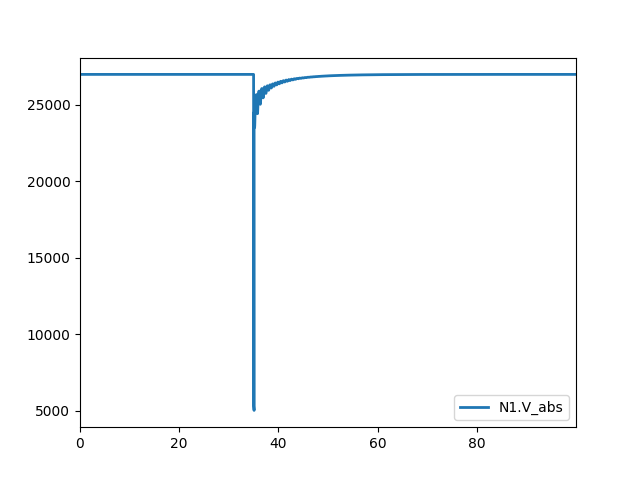

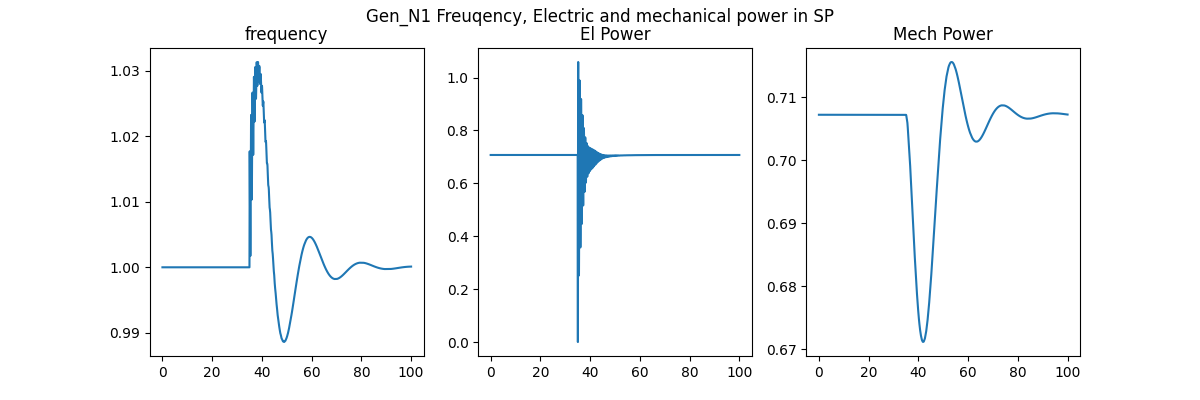

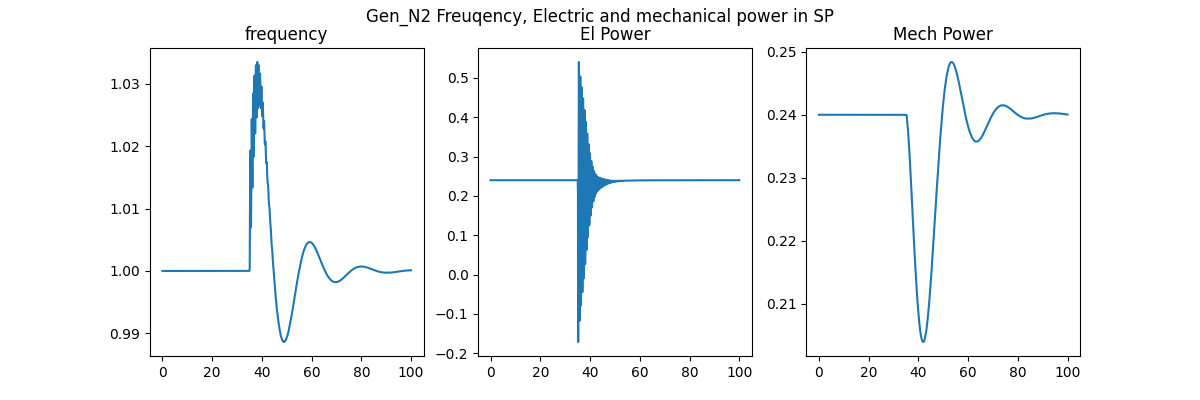

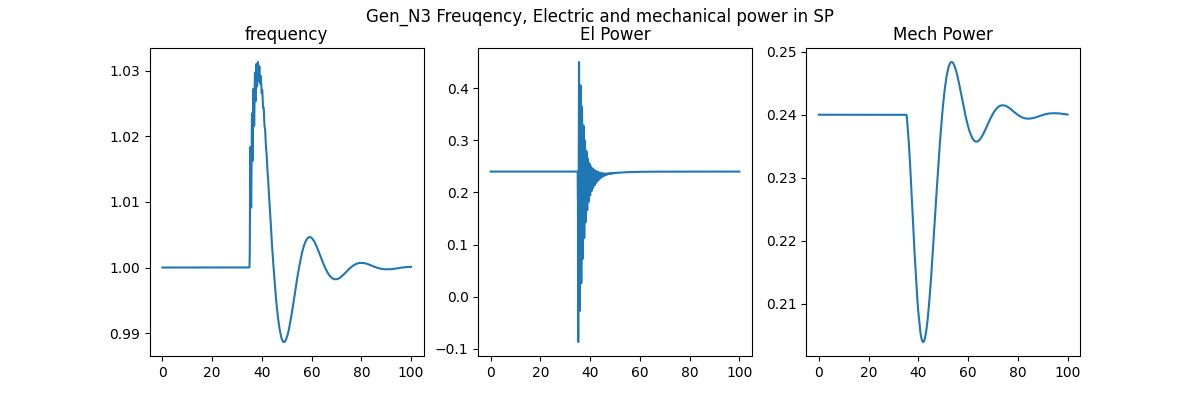

In [12]:
dpsim_result_file = 'logs/' + sim_name_dyn_sp + '/' + sim_name_dyn_sp + '.csv'
ts_dpsim_sp = read_timeseries_csv(dpsim_result_file)
phasors = ts.phasors(ts_dpsim_sp)

pt.plot_timeseries(2, phasors['N1.V']['abs'])

for gen_name in ["Gen_N1", "Gen_N2", "Gen_N3"]:
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(12, 4))
    fig.suptitle(gen_name+' Freuqency, Electric and mechanical power in SP')
    frequency= ts_dpsim_sp[gen_name+'.w'].values
    Epower= ts_dpsim_sp[gen_name+'.Pe'].values
    Mpower= ts_dpsim_sp[gen_name+'.Pm'].values
    t=ts_dpsim_sp[gen_name+'.Pe'].time
    print(t)
    print(frequency)
    ax1.plot(t, frequency)
    ax2.plot(t, Epower)
    ax3.plot(t, Mpower)
    ax1.set_title('frequency')
    ax2.set_title('El Power')
    ax3.set_title('Mech Power')

Read EMT und DP

In [9]:
dpsim_result_file = 'logs/' + sim_name_dyn_dp + '/' + sim_name_dyn_dp + '.csv'
ts_dpsim_dp = read_timeseries_csv(dpsim_result_file)

dpsim_result_file = 'logs/' + sim_name_dyn_emt + '/' + sim_name_dyn_emt + '.csv'
ts_dpsim_emt = read_timeseries_csv(dpsim_result_file)

column number: 19
results length: 25001
real column names: ['Gen_N1.Pe', 'Gen_N1.w', 'Gen_N2.Pe', 'Gen_N2.w', 'Gen_N3.Pe', 'Gen_N3.w']
complex column names: ['N1.V', 'N10.V', 'N11.V', 'N12.V', 'N2.V', 'N3.V', 'N4.V', 'N5.V', 'N6.V', 'N7.V', 'N8.V', 'N9.V', 'gnd.V']
column number: 43
results length: 25001
real column names: ['Gen_N1.Pe', 'Gen_N1.w', 'Gen_N2.Pe', 'Gen_N2.w', 'Gen_N3.Pe', 'Gen_N3.w', 'N1.V_0', 'N1.V_1', 'N1.V_2', 'N10.V_0', 'N10.V_1', 'N10.V_2', 'N11.V_0', 'N11.V_1', 'N11.V_2', 'N12.V_0', 'N12.V_1', 'N12.V_2', 'N2.V_0', 'N2.V_1', 'N2.V_2', 'N3.V_0', 'N3.V_1', 'N3.V_2', 'N4.V_0', 'N4.V_1', 'N4.V_2', 'N5.V_0', 'N5.V_1', 'N5.V_2', 'N6.V_0', 'N6.V_1', 'N6.V_2', 'N7.V_0', 'N7.V_1', 'N7.V_2', 'N8.V_0', 'N8.V_1', 'N8.V_2', 'N9.V_0', 'N9.V_1', 'N9.V_2', 'gnd.V']
complex column names: []


Definition of a Plot Function

In [10]:
def plot_node_volt_abs(varname_dpsim, ts_dpsim_sp, ts_dpsim_dp, nominal_voltage, timestep_common):
   
    width = 12
    height = 4 
    t_begin = 0
    t_end = 40
    begin_idx = int(t_begin/timestep_common)
    end_idx= int(t_end/timestep_common)
    time = np.linspace(t_begin, t_end, num=end_idx-begin_idx)
    #convert dpsim voltage to magnitude value and per-unit for comparison with psat
    dpsim_sp_values_abs_pu = ts_dpsim_sp[varname_dpsim].interpolate(timestep_common).abs().values[begin_idx:end_idx]/nominal_voltage
    dpsim_dp_values_abs_pu = ts_dpsim_dp[varname_dpsim].interpolate(timestep_common).abs().values[begin_idx:end_idx]/nominal_voltage

    plt.figure(figsize=(width, height))
    #plt.plot(time, dpsim_dp_values_abs_pu, label='DP - DPsim')
    plt.plot(time, dpsim_sp_values_abs_pu, label='SP - DPsim')
    plt.legend(loc='lower right')
    plt.xlabel('time (s)')
    plt.grid()
    plt.xlim([0,40])
    plt.show()

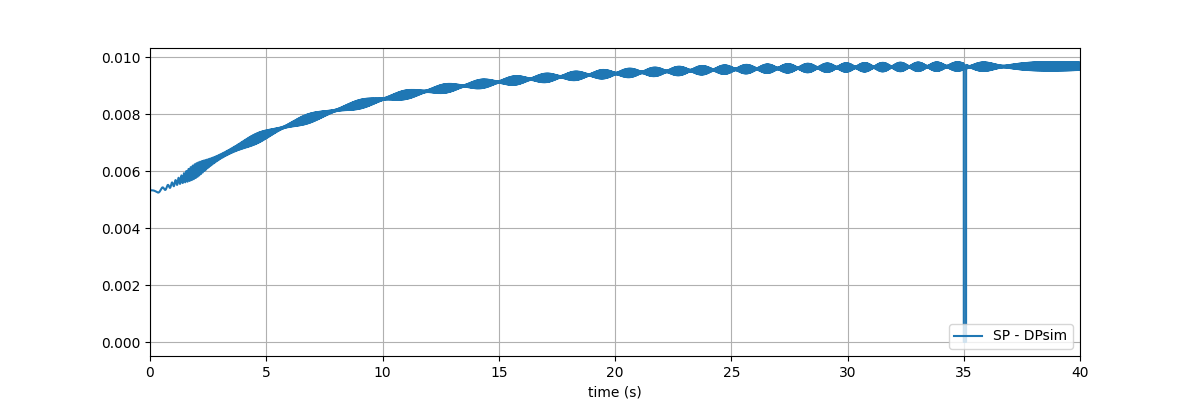

In [11]:
varname_dpsim = 'N4.V'
varname_psat = 'V_Bus04'
nominal_voltage = 400000
plot_node_volt_abs(varname_dpsim, ts_dpsim_sp, ts_dpsim_dp, nominal_voltage, 0.001)

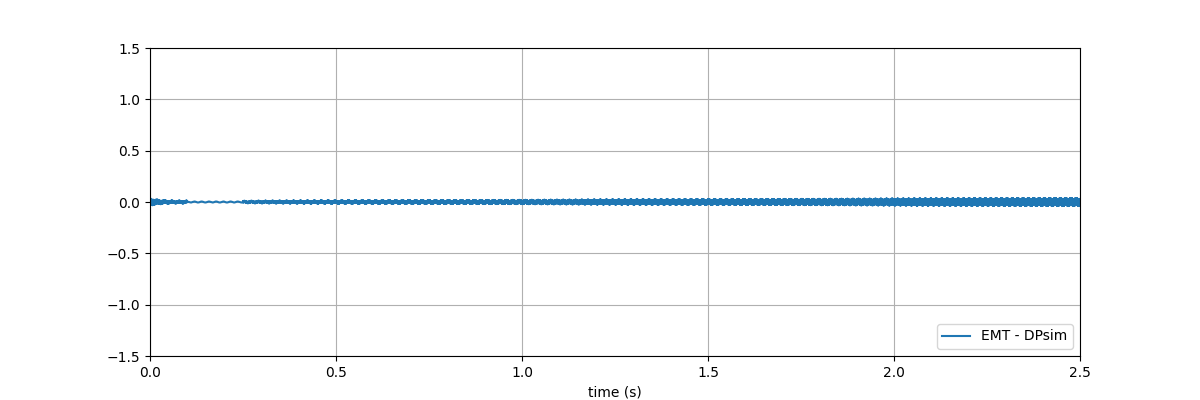

In [12]:
timestep_common = 1e-4
t_begin = 0
t_end = 2.5
begin_idx = int(t_begin/timestep_common)
end_idx= int(t_end/timestep_common)
time = np.linspace(t_begin, t_end, num=end_idx-begin_idx)

#plot parameters
width = 12
height = 4

varname_dpsim = 'N4.V_0'
nominal_voltage = 400000*math.sqrt(2/3) 

dpsim_dp_values = (ts_dpsim_emt[varname_dpsim].interpolate(timestep_common).values[begin_idx:end_idx]/nominal_voltage).real

plt.figure(figsize=(width, height))
plt.plot(time, dpsim_dp_values, label='EMT - DPsim')

plt.legend(loc='lower right')
plt.xlabel('time (s)')
plt.grid()
plt.ylim([-1.5, 1.5])
plt.xlim([0, 2.5])
plt.show()

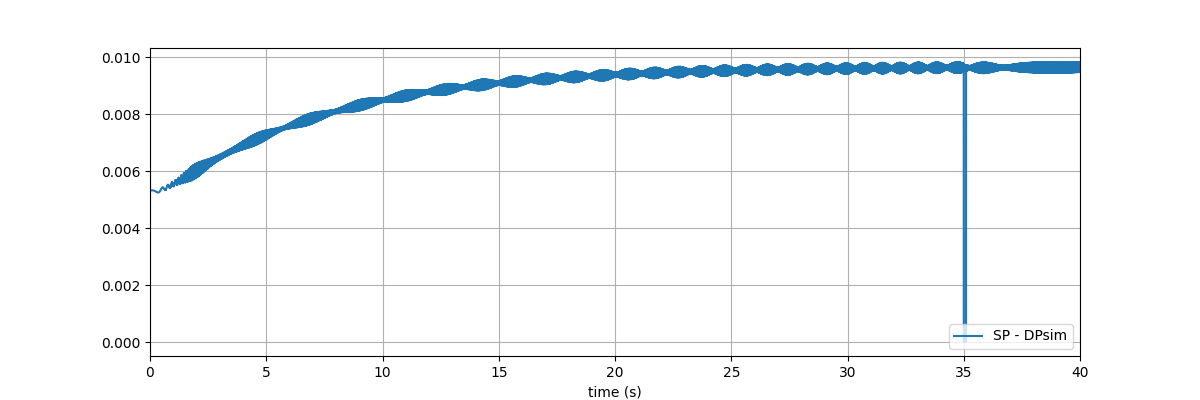

In [13]:
varname_dpsim = 'N4.V'
varname_psat = 'V_Bus04'
nominal_voltage = 400000
plot_node_volt_abs(varname_dpsim, ts_dpsim_sp, ts_dpsim_dp, nominal_voltage, timestep_common=0.0001)

Resulst of IAEW

Text(0.5, 1.0, 'Mech Power')

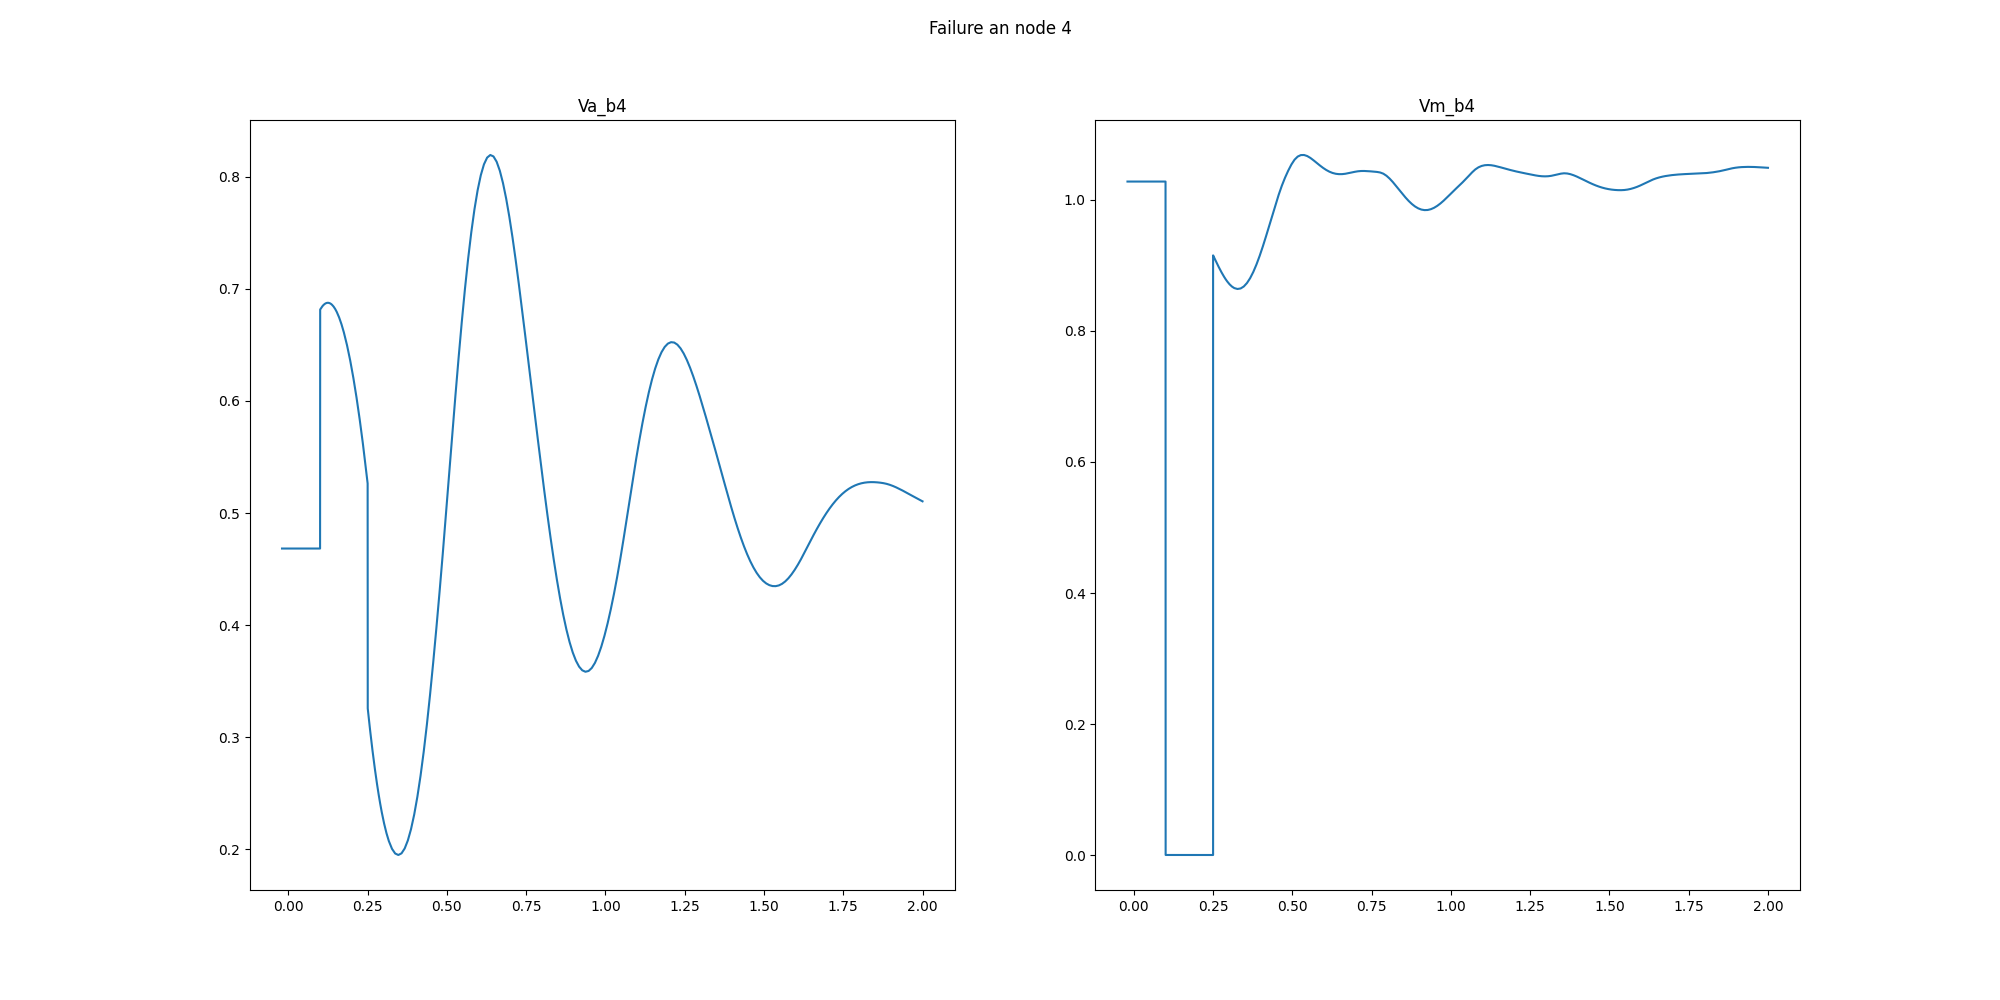

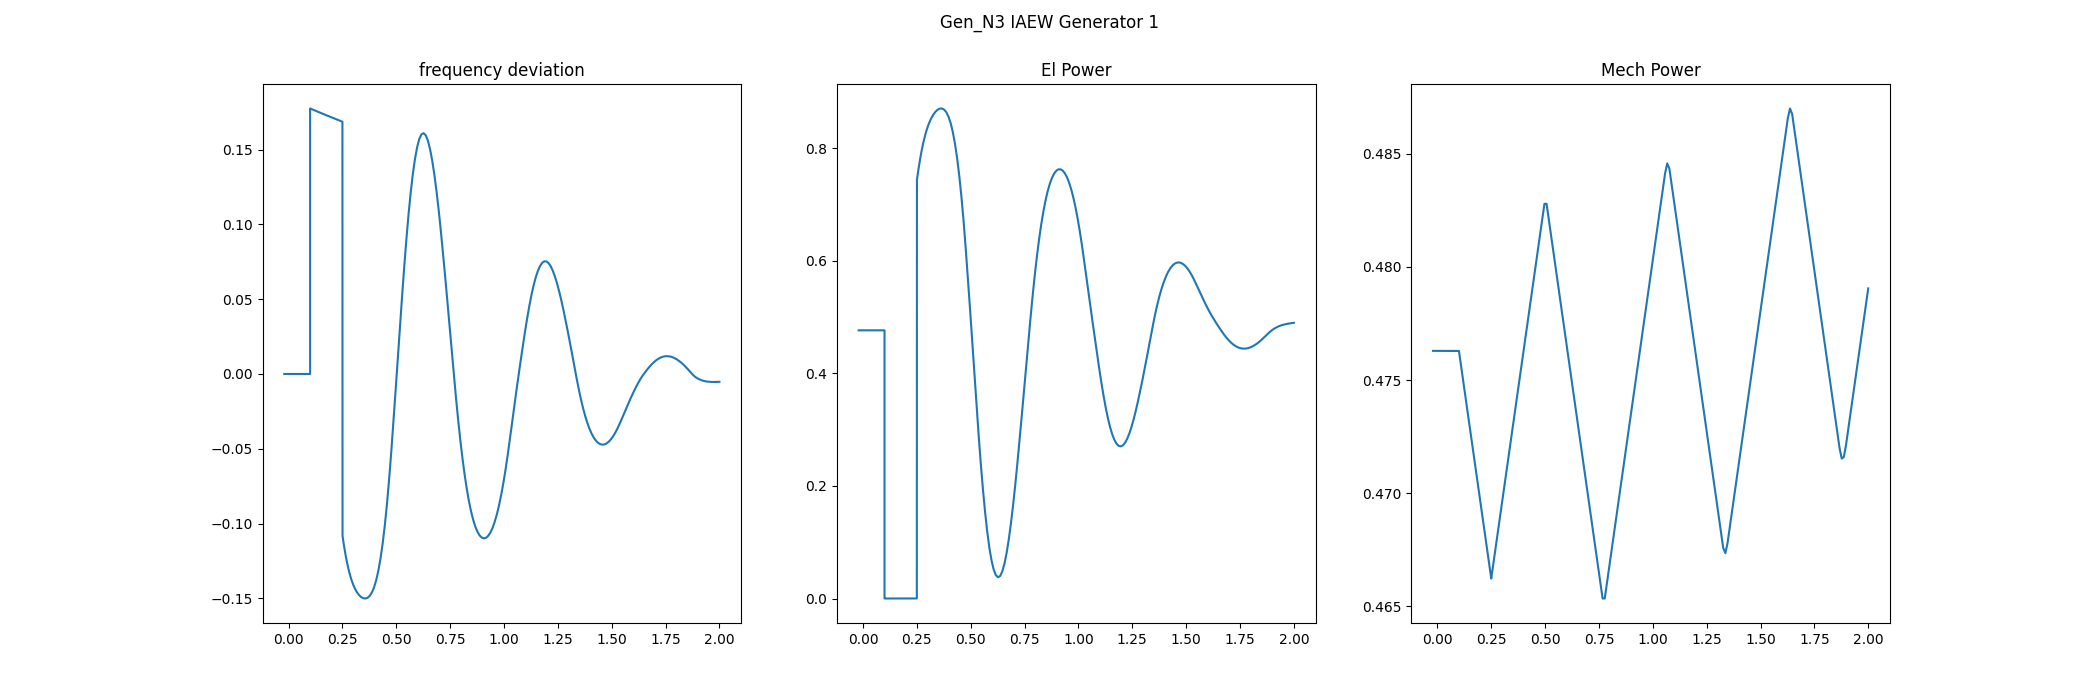

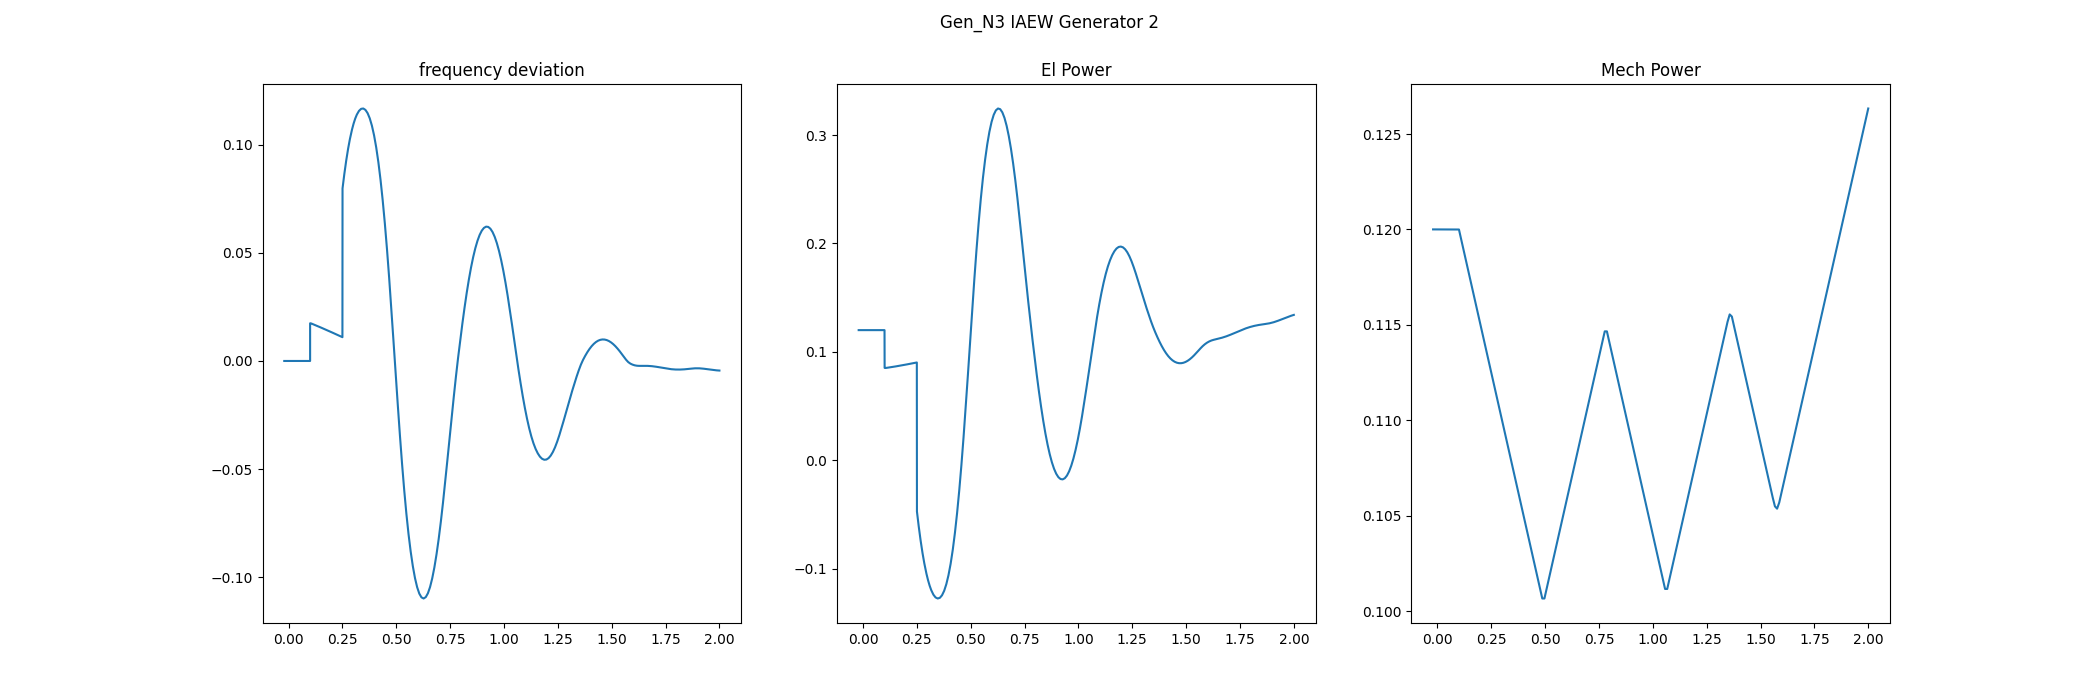

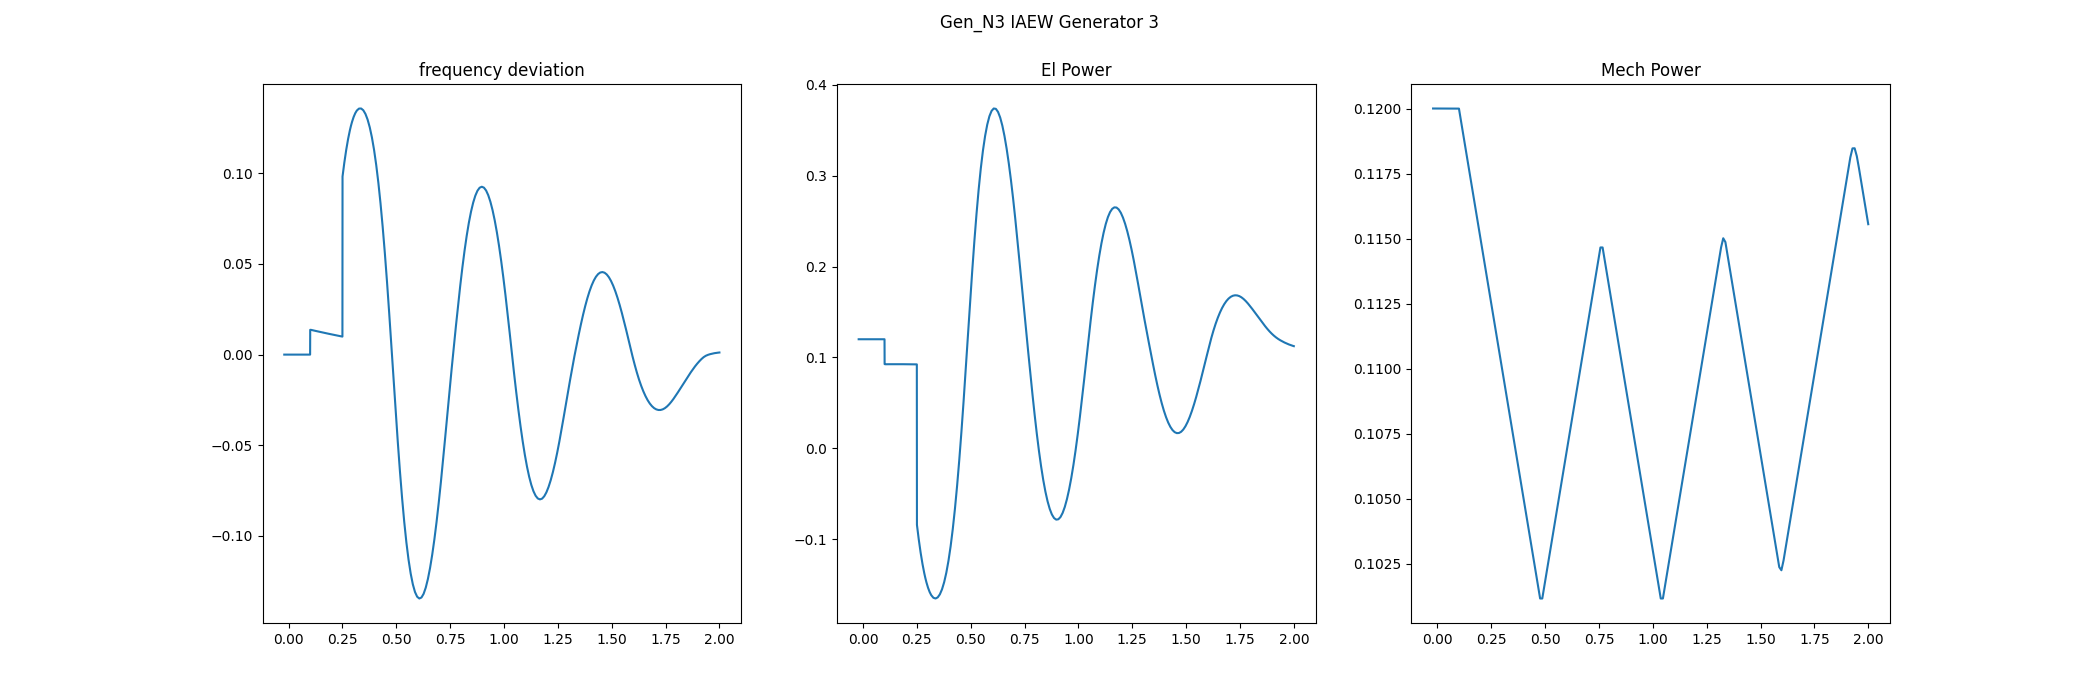

In [14]:
import scipy.io
import matplotlib.pyplot as plt

path_file = '/home/mmo-gog/dpsim/examples/Notebooks/9BusValidations/Static_Dynamic_Data_9Bus_System_incl_simulations.mat'
iaew_results = scipy.io.loadmat(path_file, simplify_cells= True)
iaew_time=iaew_results['res_dyn_only_SYN']['Time']
#Voltage at Node 
Va_b4=iaew_results['res_dyn_only_SYN']['Variables'][:,6]
Vm_b4=iaew_results['res_dyn_only_SYN']['Variables'][:,7]

#Plot Voltage at Node 4
fig1, (ax1, ax2) = plt.subplots(1, 2,figsize=(20, 10))
fig1.suptitle('Failure an node 4')
ax1.plot(iaew_time, Va_b4)
ax2.plot(iaew_time, Vm_b4)
ax1.set_title('Va_b4')
ax2.set_title('Vm_b4')

#Generator 1
fig2, (p1, p2, p3)= plt.subplots(1, 3,figsize=(21, 7))
fig2.suptitle(gen_name+' IAEW Generator 1')
g1_domeg= iaew_results['res_dyn_only_SYN']['Variables'][:,78]
g1_Pe= iaew_results['res_dyn_only_SYN']['Variables'][:,121]
g1_Pm= iaew_results['res_dyn_only_SYN']['Variables'][:,26]
p1.plot(iaew_time, g1_domeg)
p2.plot(iaew_time, g1_Pe)
p3.plot(iaew_time, g1_Pm)
p1.set_title('frequency deviation')
p2.set_title('El Power')
p3.set_title('Mech Power')

#Generator 2
fig2, (p4, p5, p6)= plt.subplots(1, 3,figsize=(21, 7))
fig2.suptitle(gen_name+' IAEW Generator 2')
g2_domeg= iaew_results['res_dyn_only_SYN']['Variables'][:,80]
g2_Pe= iaew_results['res_dyn_only_SYN']['Variables'][:,122]
g2_Pm= iaew_results['res_dyn_only_SYN']['Variables'][:,34]
p4.plot(iaew_time, g2_domeg)
p5.plot(iaew_time, g2_Pe)
p6.plot(iaew_time, g2_Pm)
p4.set_title('frequency deviation')
p5.set_title('El Power')
p6.set_title('Mech Power')

#Generator 3
fig3, (p7, p8, p9)= plt.subplots(1, 3,figsize=(21, 7))
fig3.suptitle(gen_name+' IAEW Generator 3')
g3_domeg= iaew_results['res_dyn_only_SYN']['Variables'][:,82]
g3_Pe= iaew_results['res_dyn_only_SYN']['Variables'][:,123]
g3_Pm= iaew_results['res_dyn_only_SYN']['Variables'][:,42]
p7.plot(iaew_time, g3_domeg)
p8.plot(iaew_time, g3_Pe)
p9.plot(iaew_time, g3_Pm)
p7.set_title('frequency deviation')
p8.set_title('El Power')
p9.set_title('Mech Power')
